## Method 1: LayoutParser Library

#### Install libraries

In [ ]:
!pip install -U layoutparser
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 
!pip install layoutparser[ocr]      
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

In [1]:
import pdf2image
from PIL import Image
import layoutparser as lp
import cv2
import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#### Read PDF sample file

In [28]:
def pdf_to_image_save():
    doc = pdf2image.convert_from_path("81109144_Sahoo Shashank_stress.pdf")

    print(len(doc)) #<-- check num pages
    # print(doc[0])   #<-- visualize a page
    print(type(doc[0]))

    # for count, page in enumerate(doc):
    #     page.save(f'out{count}.jpg', 'JPEG')
    #     im = Image.open(f'out{count}.jpg')
    #     im.show()
    return doc

#### Sample 1: Run Layout Parser for DLC - Document Layout Component detection

In [3]:
def dlc_detection(doc):
    ## load pre-trained model
    model = lp.Detectron2LayoutModel("lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config",
                extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                label_map={0:"Text", 1:"Title", 2:"List", 3:"Table", 4:"Figure"})
    ## turn img into array
    i = 5
    img = np.asarray(doc[i])
    print(type(img), img.shape)
    ## predict
    detected = model.detect(img)
    ## plot
    lp.draw_box(img, detected, box_width=5, box_alpha=0.2, 
                show_element_type=False).show()
    return detected, img
    

In [19]:
doc = pdf_to_image_save()

8
<class 'PIL.PpmImagePlugin.PpmImageFile'>


In [20]:
detected, img = dlc_detection(doc)

[2023-08-10 19:38:29,252] [ WARNING] checkpoint.py:352 - The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


<class 'numpy.ndarray'> (2339, 1653, 3)


In [21]:
detected[0].block.coordinates

(324.8722839355469, 742.2815551757812, 1498.331298828125, 1443.33984375)

In [22]:
## sort
new_detected = detected.sort(key=lambda x: x.coordinates[1])
## assign ids
detected = lp.Layout([block.set(id=idx) for idx,block in 
                      enumerate(new_detected)])
## check
for block in detected:
    print("---", str(block.id)+":", block.type, "---")
    print(block.block)
    print(block.block.coordinates)
    print(block, end='\n\n')

--- 0: Text ---
Rectangle(x_1=285.2196350097656, y_1=232.38751220703125, x_2=1499.315673828125, y_2=371.01220703125)
(285.2196350097656, 232.38751220703125, 1499.315673828125, 371.01220703125)
TextBlock(block=Rectangle(x_1=285.2196350097656, y_1=232.38751220703125, x_2=1499.315673828125, y_2=371.01220703125), text=None, id=0, type=Text, parent=None, next=None, score=0.8381154537200928)

--- 1: Text ---
Rectangle(x_1=272.4722900390625, y_1=393.0809326171875, x_2=1497.9403076171875, y_2=610.4217529296875)
(272.4722900390625, 393.0809326171875, 1497.9403076171875, 610.4217529296875)
TextBlock(block=Rectangle(x_1=272.4722900390625, y_1=393.0809326171875, x_2=1497.9403076171875, y_2=610.4217529296875), text=None, id=1, type=Text, parent=None, next=None, score=0.9677276611328125)

--- 2: List ---
Rectangle(x_1=324.8722839355469, y_1=742.2815551757812, x_2=1498.331298828125, y_2=1443.33984375)
(324.8722839355469, 742.2815551757812, 1498.331298828125, 1443.33984375)
TextBlock(block=Rectangle(x

In [26]:
model = lp.TesseractAgent(languages='eng')

In [27]:
dic_predicted = {}

In [28]:
'''
{'0-Title': '...',
 '1-Text':  '...', 
 '2-Figure': array([[ [0,0,0], ...]]),
 '3-Table': pd.DataFrame,
}
'''
def parse_doc(dic):
    for k,v in dic.items():
        if "Title" in k:
            print('\x1b[1;31m'+ v +'\x1b[0m')
        elif "Figure" in k:
            plt.figure(figsize=(10,5))
            plt.imshow(v)
            plt.show()
        else:
            print(v)
        print(" ")

In [30]:
for block in [block for block in detected if block.type in ["Title", "Text"]]:
    ## segmentation
    segmented = block.pad(left=15, right=15, top=5, bottom=5).crop_image(img)
    ## extraction
    extracted = model.detect(segmented)
    ## save
    dic_predicted[str(block.id)+"-"+block.type] = extracted.replace('\n',' ').strip()

dic_predicted

{'0-Text': 'of the locations owned by DSB, business partner/client/supplier (authorized persons or employees) evaluation process, reputation surveys, legal compliance, audit, financial transactions, etc.), determination and implementation of commercial and business strategies and exercise of human resources, business development and risk analysis policies of DSB.',
 '1-Text': 'c) Methodology and the Legal Ground of Obtaining Personal Data: Personal data is collected via all kinds of verbal, written or electronic means in order for DSB to provide products and services within the legal framework and to perform obligations of DSB to be fulfilled whole and complete arising out of agreement and from the law. For this reason, personal data may also be processed for the purposes specified in subparagraphs (a) and (b) under the conditions and purposes of personal data processing specified in articles 5 and 6 of the PPDL.',
 '3-Text': '7.2. DSB undertakes that it will process and keep the Perso

In [31]:
for block in [block for block in detected if block.type == "Figure"]:
    ## segmentation
    segmented = block.pad(left=15, right=15, top=5, bottom=5).crop_image(img)
    ## save
    dic_predicted[str(block.id)+"-"+block.type] = segmented

# check
parse_doc(dic_predicted)

of the locations owned by DSB, business partner/client/supplier (authorized persons or employees) evaluation process, reputation surveys, legal compliance, audit, financial transactions, etc.), determination and implementation of commercial and business strategies and exercise of human resources, business development and risk analysis policies of DSB.
 
c) Methodology and the Legal Ground of Obtaining Personal Data: Personal data is collected via all kinds of verbal, written or electronic means in order for DSB to provide products and services within the legal framework and to perform obligations of DSB to be fulfilled whole and complete arising out of agreement and from the law. For this reason, personal data may also be processed for the purposes specified in subparagraphs (a) and (b) under the conditions and purposes of personal data processing specified in articles 5 and 6 of the PPDL.
 
7.2. DSB undertakes that it will process and keep the Personal Data that it collected during th

In [32]:
for block in [block for block in detected if block.type == "Table"]:
    ## segmentation
    segmented = block.pad(left=15, right=15, top=5, 
                bottom=5).crop_image(img)
    ## extraction
    extracted = model.detect(segmented)
    ## save
    dic_predicted[str(block.id)+"-"+block.type] = pd.read_csv( 
                 io.StringIO(extracted) )
# check
parse_doc(dic_predicted)

of the locations owned by DSB, business partner/client/supplier (authorized persons or employees) evaluation process, reputation surveys, legal compliance, audit, financial transactions, etc.), determination and implementation of commercial and business strategies and exercise of human resources, business development and risk analysis policies of DSB.
 
c) Methodology and the Legal Ground of Obtaining Personal Data: Personal data is collected via all kinds of verbal, written or electronic means in order for DSB to provide products and services within the legal framework and to perform obligations of DSB to be fulfilled whole and complete arising out of agreement and from the law. For this reason, personal data may also be processed for the purposes specified in subparagraphs (a) and (b) under the conditions and purposes of personal data processing specified in articles 5 and 6 of the PPDL.
 
7.2. DSB undertakes that it will process and keep the Personal Data that it collected during th

In [33]:
for block in [block for block in detected if block.type == "List"]:
    ## segmentation
    segmented = block.pad(left=15, right=15, top=5, 
                bottom=5).crop_image(img)
    ## extraction
    extracted = model.detect(segmented)
    ## save
    dic_predicted[str(block.id)+"-"+block.type] = pd.read_csv(io.StringIO(extracted))
# check
parse_doc(dic_predicted)

ParserError: Error tokenizing data. C error: Expected 2 fields in line 11, saw 3


#### Sample 2: Run Layout Parser for DLC - Document Layout Component detection

In [34]:

img = Image.open("test_image_samples/2.tar_1401.0812.gz_NewversionArXiv_28_ori.jpg")

## load pre-trained model
model = lp.Detectron2LayoutModel("lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config",
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
            label_map={0:"Text", 1:"Title", 2:"List", 3:"Table", 4:"Figure"})
## turn img into array
# i = 5
# img = np.asarray(doc[i])
## predict
detected = model.detect(img)
## plot
lp.draw_box(img, detected, box_width=5, box_alpha=0.2, 
            show_element_type=True).show()

lp.draw_box(img, detected, box_width=5, box_alpha=0.2, 
            show_element_type=True).save("layout_parser_results.png")

[2023-08-10 19:42:57,042] [ WARNING] checkpoint.py:352 - The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


## Method 2: Paddle OCR Library

#### Install libraries

In [ ]:
!python3 -m pip install paddlepaddle-gpu
!pip install "paddleocr>=2.0.1"

#### Run PaddleOCR for DLC - Document Layout Component detection

In [37]:
from paddleocr import PaddleOCR, draw_ocr

# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `fr`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang="en", page_num=2)  # need to run only once to download and load model into memory
img_path = "test_image_samples/2.tar_1401.0812.gz_NewversionArXiv_28_ori.jpg"
%timeit 
result = ocr.ocr(img_path, cls=True)

[2023/08/10 19:45:43] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=2, det_algorithm='DB', det_model_dir='/Users/shashanksahoo/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/shashanksahoo/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, 

In [38]:
result

[[[[[318.0, 361.0], [361.0, 366.0], [359.0, 376.0], [317.0, 371.0]],
   ('+', 0.5830063819885254)],
  [[[469.0, 365.0], [487.0, 365.0], [487.0, 377.0], [469.0, 377.0]],
   ('2r', 0.7973127365112305)],
  [[[517.0, 361.0], [538.0, 364.0], [536.0, 376.0], [515.0, 373.0]],
   ('R.', 0.7348412871360779)],
  [[[335.0, 568.0], [421.0, 568.0], [421.0, 578.0], [335.0, 578.0]],
   ('AAAA', 0.8131182193756104)],
  [[[147.0, 618.0], [586.0, 618.0], [586.0, 632.0], [147.0, 632.0]],
   ('Figure 2:Illustration of the division of sets for the proof of Theorem 4.2',
    0.9497135281562805)],
  [[[96.0, 659.0], [638.0, 659.0], [638.0, 674.0], [96.0, 674.0]],
   ('implies that uxx+2o for some small >0 and for all  AThus,by the',
    0.9139682054519653)],
  [[[96.0, 676.0], [638.0, 676.0], [638.0, 691.0], [96.0, 691.0]],
   ('continuity with respect to X,we see that u+s + for all x  A for  small',
    0.87956702709198)],
  [[[95.0, 695.0], [226.0, 695.0], [226.0, 709.0], [95.0, 709.0]],
   ('enough,which 

In [39]:
len(result[0])

18

In [40]:
result[0][0]

[[[318.0, 361.0], [361.0, 366.0], [359.0, 376.0], [317.0, 371.0]],
 ('+', 0.5830063819885254)]

In [41]:
for line in result:
    print(line)

[[[[318.0, 361.0], [361.0, 366.0], [359.0, 376.0], [317.0, 371.0]], ('+', 0.5830063819885254)], [[[469.0, 365.0], [487.0, 365.0], [487.0, 377.0], [469.0, 377.0]], ('2r', 0.7973127365112305)], [[[517.0, 361.0], [538.0, 364.0], [536.0, 376.0], [515.0, 373.0]], ('R.', 0.7348412871360779)], [[[335.0, 568.0], [421.0, 568.0], [421.0, 578.0], [335.0, 578.0]], ('AAAA', 0.8131182193756104)], [[[147.0, 618.0], [586.0, 618.0], [586.0, 632.0], [147.0, 632.0]], ('Figure 2:Illustration of the division of sets for the proof of Theorem 4.2', 0.9497135281562805)], [[[96.0, 659.0], [638.0, 659.0], [638.0, 674.0], [96.0, 674.0]], ('implies that uxx+2o for some small >0 and for all  AThus,by the', 0.9139682054519653)], [[[96.0, 676.0], [638.0, 676.0], [638.0, 691.0], [96.0, 691.0]], ('continuity with respect to X,we see that u+s + for all x  A for  small', 0.87956702709198)], [[[95.0, 695.0], [226.0, 695.0], [226.0, 709.0], [95.0, 709.0]], ('enough,which means', 0.9586436748504639)], [[[273.0, 710.0], [45

In [42]:
result[0][0][1]

('+', 0.5830063819885254)

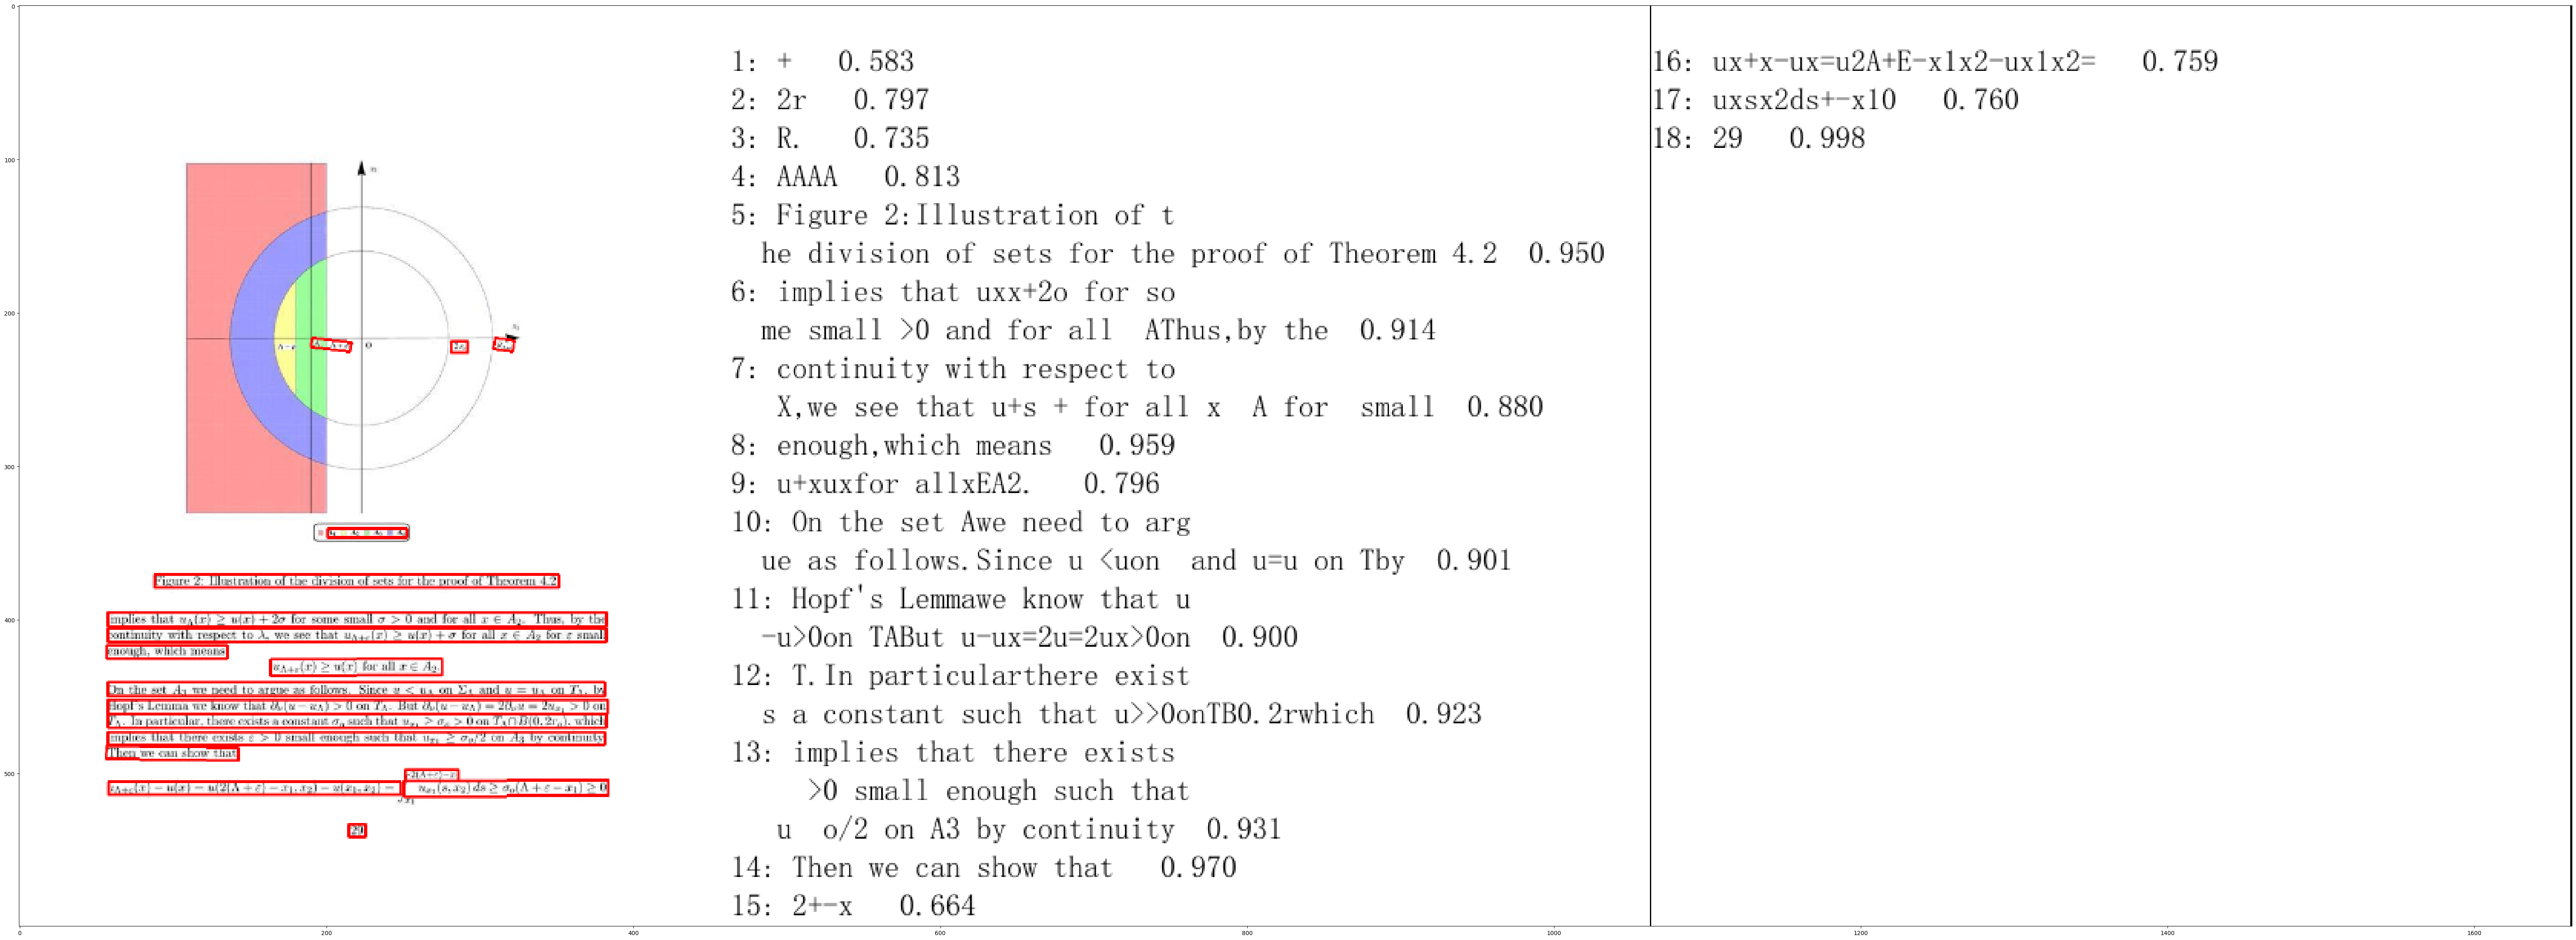

In [43]:
# draw result
from PIL import Image, ImageDraw, ImageFont

# draw result
from PIL import Image
image = Image.open(img_path).convert('RGB')
boxes = [detection[0] for line in result for detection in line] # Nested loop added
txts = [detection[1][0] for line in result for detection in line] # Nested loop added
scores = [detection[1][1] for line in result for detection in line] # Nested loop added

im_show = draw_ocr(image, boxes, txts, scores, font_path='simfang.ttf')
im_show = Image.fromarray(im_show)
im_show.save('test.jpg')
plt.figure(figsize=(80, 100))
plt.imshow(im_show)

## Method 3: EasyOCR

#### Install libraries

In [44]:
!pip install easyocr

  Obtaining dependency information for easyocr from https://files.pythonhosted.org/packages/f7/72/403670eff77ee3818858cce05e8f7cbbbe81619fff4ab6efd11533c9a03f/easyocr-1.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/73/0e/c21b4b32e5898f6940d8700b5715b7dd641261daae347c11599bb4c4da2a/opencv_python_headless-4.8.0.76-cp37-abi3-macosx_10_16_x86_64.whl.metadata
  Using cached ninja-1.11.1-py2.py3-none-macosx_10_9_universal2.macosx_10_9_x86_64.macosx_11_0_arm64.macosx_11_0_universal2.whl (270 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 6.0 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:01


#### Run EasyOCR for DLC - Document Layout Component detection

In [4]:
import easyocr
reader = easyocr.Reader(['ch_sim','en']) # this needs to run only once to load the model into memory
result = reader.readtext('test_image_samples/out0.jpg')

In [5]:
result

[([[1062, 298], [1493, 298], [1493, 352], [1062, 352]],
  "For Information Purposes'",
  0.9171057079279901),
 ([[1338, 684], [1504, 684], [1504, 714], [1338, 714]],
  'Contract No:',
  0.8559494318808007),
 ([[223, 779], [516, 779], [516, 823], [223, 823]],
  'Akamatsu Consulting',
  0.8739790957457305),
 ([[219, 856], [803, 856], [803, 896], [219, 896]],
  'Fulya Mah. Sehit Niyazi Sk. Ugur Apt.N:15/8',
  0.699479734836872),
 ([[223, 889], [505, 889], [505, 929], [223, 929]],
  'Mecidiyekoy ,Istanbul',
  0.7335693598158903),
 ([[221, 1076], [696, 1076], [696, 1116], [221, 1116]],
  'This Engagement Letter Will confirm',
  0.5916384059257183),
 ([[702, 1082], [748, 1082], [748, 1106], [702, 1106]],
  'OUr',
  0.5535290923952759),
 ([[750, 1071], [1505, 1071], [1505, 1116], [750, 1116]],
  'understanding Of the engagement Of DSB. (hercinafter also',
  0.5459889563169112),
 ([[220, 1109], [360, 1109], [360, 1141], [220, 1141]],
  'referred as',
  0.9638403949734687),
 ([[369, 1104], [128

In [7]:
# total components detected by EasyOCR
len(result)

43

## Method 4: TrOCR

The TrOCR model was proposed in TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models by Minghao Li, Tengchao Lv, Lei Cui, Yijuan Lu, Dinei Florencio, Cha Zhang, Zhoujun Li, Furu Wei. TrOCR consists of an image Transformer encoder and an autoregressive text Transformer decoder to perform optical character recognition (OCR).

TrOCR’s VisionEncoderDecoder model accepts images as input and makes use of generate() to autoregressively generate text given the input image.

The [ViTImageProcessor/DeiTImageProcessor] class is responsible for preprocessing the input image and [RobertaTokenizer/XLMRobertaTokenizer] decodes the generated target tokens to the target string. The TrOCRProcessor wraps [ViTImageProcessor/DeiTImageProcessor] and [RobertaTokenizer/XLMRobertaTokenizer] into a single instance to both extract the input features and decode the predicted token ids.

In [9]:
!pip install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/21/02/ae8e595f45b6c8edee07913892b3b41f5f5f273962ad98851dc6a564bbb9/transformers-4.31.0-py3-none-any.whl.metadata
  Using cached transformers-4.31.0-py3-none-any.whl.metadata (116 kB)
  Obtaining dependency information for huggingface-hub<1.0,>=0.14.1 from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.16.4-py3-none-any.whl.metadata (12 kB)
  Using cached tokenizers-0.13.3-cp39-cp39-macosx_10_11_x86_64.whl (4.0 MB)
  Obtaining dependency information for safetensors>=0.3.1 from https://files.pythonhosted.org/packages/44/e8/ceefc84c6d944dc18d51ff4cd5bbcad0c7c0e3f4acaaf3849185022c59e3/safetensors-0.3.2-cp39-cp39-macosx_13_0_x86_64.whl.metadata
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/e3/bd/4c0a4619494188a9

In [10]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# load image from the IAM dataset
url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

/Users/shashanksahoo/miniconda3/envs/paddle-ocr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/shashanksahoo/miniconda3/envs/paddle-ocr/lib/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecate

In [11]:
generated_text

'industry, " Mr. Brown commented icily. " Let us have a'

In [26]:
url = "https://techmonitor.ai/wp-content/uploads/sites/4/2016/06/what-is-URL.jpg"

image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
print(generated_ids)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

tensor([[    2, 42703,  2054,  1662,    12, 34264,  3137,     2]])


In [27]:
generated_text

'URL http www-ingen com'

## References

1. https://towardsdatascience.com/analyzing-document-layout-with-layoutparser-ed24d85f1d44
2. https://towardsdatascience.com/document-parsing-with-python-ocr-75543448e581
3. https://github.com/RajkumarGalaxy/ComputerVision/blob/master/LayoutParser_table_OCR.ipynb
4. https://analyticsindiamag.com/guide-to-layoutparser-a-document-image-analysis-python-library/
5. https://github.com/JaidedAI/EasyOCR
6. https://www.jaided.ai/easyocr/modelhub/
7. https://huggingface.co/docs/transformers/model_doc/trocr